In [23]:
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
%matplotlib notebook

In [24]:
# todo example track from csv
track = np.array([
                [0, 2, 2, 2, 0, 0],
                [0, 1, 1, 1, 0, 0],
                [0, 1, 0, 0, 0, 0],
                [0, 1, 1, 1, 0, 0],
                [0, 1, 1, 1, 1, 0],
                [0, 0, 0, 1, 1, 0],
                [0, 0, 1, 1, 1, 0],
                [0, 1, 1,1, 0,  0],
                [0, 0, 1,1, 1,  0],
                [0, 0, 1,1, 1,  3],    
                [0, 0, 0, 1, 1, 3],]
                )

<IPython.core.display.Javascript object>


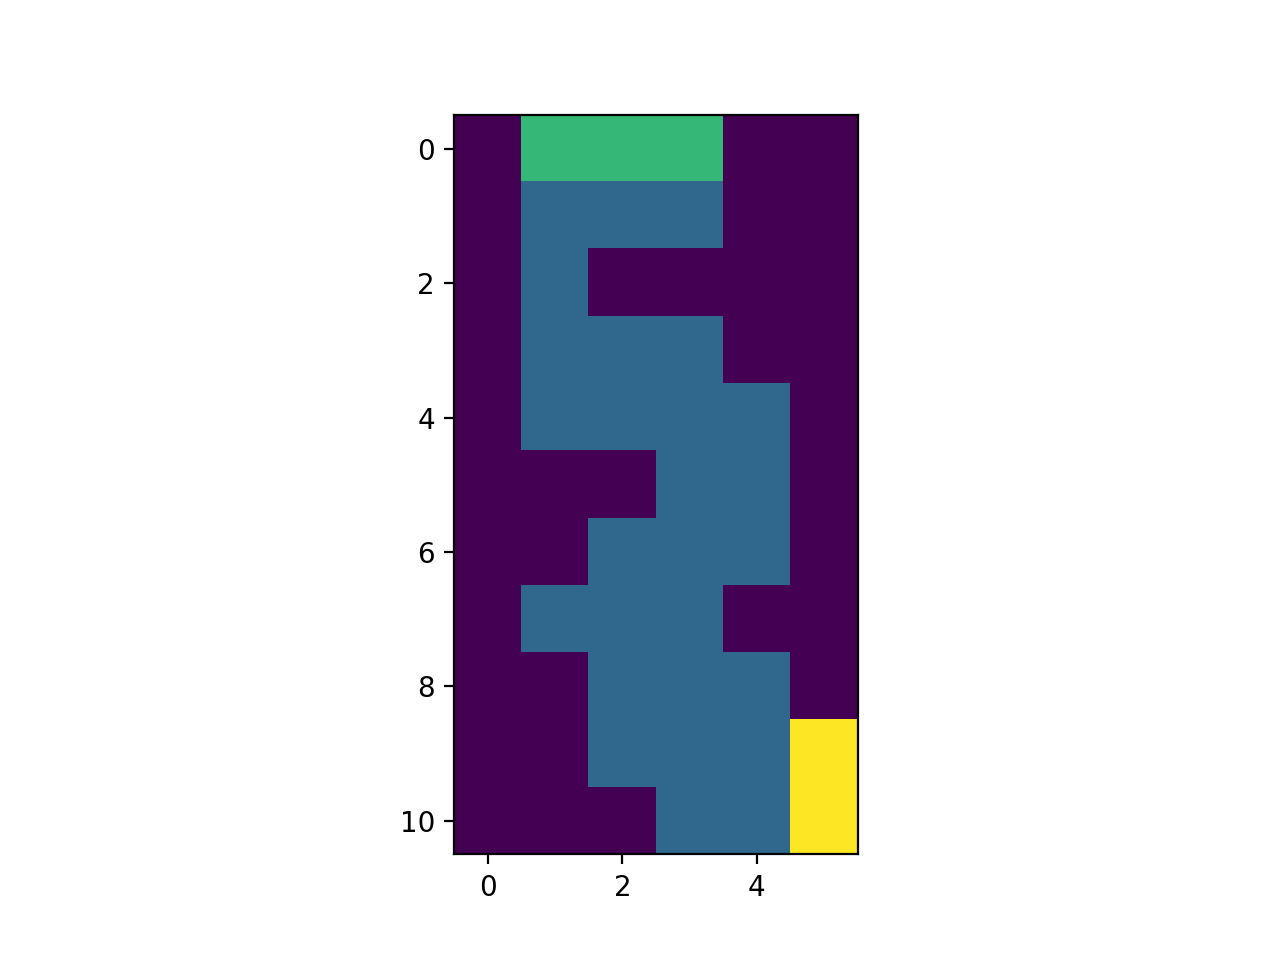

In [25]:
plt.imshow(track)

In [26]:
class RaceTrack:
    """Class that represents the environment"""
    def __init__(self, track):
        self.track = track
        self.MAX_HEIGHT = track.shape[0] - 1
        self.MAX_WIDTH = track.shape[1] - 1
        self.start_line = np.argwhere(track == 2)
        self.finish_line = np.argwhere(track == 3)

    def check_collisions(self, car_position):
        return car_position[0] < 0 or car_position[1] < 0 or car_position[0] > self.MAX_HEIGHT or car_position[1] > self.MAX_WIDTH or np.all(self.track[car_position[0], car_position[1]] == 0)
    
    def check_finish_line(self, car_position):
        return (car_position[0] in self.finish_line[:,0] and np.all(car_position[1] >= self.finish_line[:,1]))

In [27]:
class Car:
    """Class that controls the car, keeps the position and speed"""
    def __init__(self, start):
        self.position = start
        self.speed = np.zeros(2, dtype='int')
        self.path = []
        self.path.append(self.position)
            
    def move(self):
        new_pos = self.position + self.speed
        self.position = new_pos
        self.path.append(new_pos)
        
    def reset(self, start):
        self.position = start
        self.speed = np.zeros(2, dtype='int')
        self.path.append(self.position)

# Actions: dictionary encoding the actions

In [28]:
# Actions:
ACTIONS = {
    0 : (1, 1),
    1 : (1,-1),
    2 : (1, 0),
    3 : (-1, 1), 
    4 : (-1, -1), 
    5 : (-1, 0),
    6 : (0, 1),
    7 : (0, -1),
    8 : (0, 0)
}

# States: [x,y,dx,dy] to be used in this form to access the matrices Q, Pi, etc.

In [29]:
class RandomAgent:
    """Random agent that controls the car"""
    def __init__(self):
        self.returns = 0
        
    def choose_action(self, car):
        actions = []
        for update in ACTIONS.items():
            new_value = (car.speed + update[1])
            if np.all(new_value == [0,0]) or new_value[0] < 0 or new_value[1] < 0 or new_value[0] > 4 or new_value[1] > 4:
                continue
            else:
                actions.append(update[0])
        return random.choice(actions)
    
    def update(self, reward):
        self.returns += reward
        
    def generate_episode(self, track):
        car = Car(random.choice(track.start_line))
        not_done = True
        states = []
        returns = 0
        actions = []
        while not_done:
            # Current State
            x = car.position[0]
            y = car.position[1]
            dx = car.speed[0]
            dy = car.speed[1]
            states.append([x,y,dx,dy])
            # Decide new action
            action = self.choose_action(car)
            actions.append(action)
            new_speed = car.speed + ACTIONS[action]
            car.speed = new_speed
            # Update state
            car.move()
            # Get reward
            won = track.check_finish_line(car.position)
            crash = track.check_collisions(car.position)
            if won:
                reward = 0
                not_done = False
            else:
                reward = -1
                if crash:
                    car.reset(random.choice(track.start_line))
            returns += reward
        return states, actions, returns

In [30]:
class OnPolicyAgent:
    """On policy Monte Carlo control agent"""
    def __init__(self, epsilon, track):
        # Exploration epsilon
        self.epsilon = epsilon
        self.track = track.track
        # Policy
        self.pi = np.ones([self.track.shape[0], self.track.shape[1], 6, 6, 9]) / 9
        # State-action value function
        self.q = np.zeros([self.track.shape[0], self.track.shape[1], 6, 6, 9])
        # C weights (counter of first visits to a state-action pair)
        self.C = np.zeros([self.track.shape[0], self.track.shape[1], 6, 6, 9])
    
    def generate_episode(self, track, noise=True):
        car = Car(random.choice(track.start_line))
        not_done = True
        states = []
        actions = []
        returns = []
        while not_done:
            # Current State
            x = car.position[0]
            y = car.position[1]
            dx = car.speed[0]
            dy = car.speed[1]
            states.append([x,y,dx,dy])
            # Decide new action
            action = np.random.choice(range(9), p=self.pi[x, y, dx, dy])
            actions.append(action)
            new_speed = car.speed + ACTIONS[action]
            # Validate action
            new_speed[0] = max(0,min(5, new_speed[0]))
            new_speed[1] = max(0,min(5, new_speed[1]))
            if new_speed[0] == 0 and new_speed[1] == 0:
                if np.random.choice(range(2)) == 1:
                    new_speed[0] = 1
                else:
                    new_speed[1] = 1
            # Noise
            if noise and np.random.rand()<0.1:
                new_speed = car.speed
            car.speed = new_speed
            # Update state
            car.move()
            # Get reward
            won = track.check_finish_line(car.position)
            crash = track.check_collisions(car.position)
            if won:
                reward = 0
                not_done = False
            else:
                reward = -1
                if crash:
                    car.reset(random.choice(track.start_line))
            returns.append(reward)
        return states, actions, returns
    
    def update_policy(self, S, A, R):
        G = 0
        for i in reversed(range(len(S))):
            G += R[i]
            # First visit MC
            if not (S[i], A[i]) in zip(S[:-(i)], A[:-(i)]):
                x,y,dx,dy = S[i]
                self.C[x, y, dx, dy, A[i]] += 1
                self.q[x, y, dx, dy, A[i]] += (G - self.q[x, y, dx, dy, A[i]]) / self.C[x, y, dx, dy, A[i]]
                A_aster = np.argmax(self.q[x, y, dx, dy,:])
                for a in ACTIONS:
                    if a == A_aster:
                        self.pi[x, y, dx, dy, a] = 1 - self.epsilon + self.epsilon/9
                    else:
                        self.pi[x, y, dx, dy, a] = self.epsilon/9   

In [31]:
class OffPolicyAgent:
    """Off policy Monte Carlo control agent with random exploring policy"""
    def __init__(self, track):
        self.track = track.track
        # State-action value function
        self.q = np.ones([self.track.shape[0], self.track.shape[1], 6, 6, 9])*-10
        # C weights (counter of first visits to a state-action pair)
        self.C = np.zeros([self.track.shape[0], self.track.shape[1], 6, 6, 9])
        # Policy
        self.pi = np.random.randint(0, 9, size= [self.track.shape[0], self.track.shape[1], 6, 6])

    def generate_episode(self, track, noise=True, pi=False):
        car = Car(random.choice(track.start_line))
        not_done = True
        states = []
        actions = []
        returns = []
        while not_done:
            # Current State
            x = car.position[0]
            y = car.position[1]
            dx = car.speed[0]
            dy = car.speed[1]
            states.append([x,y,dx,dy])
            # Decide new action
            if not pi:
                action = np.random.choice(range(9))
            else:
                action = self.pi[x, y, dx, dy]
            actions.append(action)
            new_speed = car.speed + ACTIONS[action]
            # Validate action
            new_speed[0] = max(0,min(5, new_speed[0]))
            new_speed[1] = max(0,min(5, new_speed[1]))
            if new_speed[0] == 0 and new_speed[1] == 0:
                if np.random.choice(range(2)) == 1:
                    new_speed[0] = 1
                else:
                    new_speed[1] = 1
            # Noise
            if noise and np.random.rand()<0.1:
                new_speed = car.speed
            car.speed = new_speed
            # Update state
            car.move()
            # Get reward
            won = track.check_finish_line(car.position)
            crash = track.check_collisions(car.position)
            if won:
                reward = 0
                not_done = False
            else:
                reward = -1
                if crash:
                    car.reset(random.choice(track.start_line))
            returns.append(reward)
        return states, actions, returns
    
    def update_policy(self, S, A, R):
        G = 0
        W = 1
        for i in reversed(range(len(S))):
            G += R[i]
            x,y,dx,dy = S[i]
            self.C[x, y, dx, dy, A[i]] += W
            self.q[x, y, dx, dy, A[i]] += (G - self.q[x, y, dx, dy, A[i]]) * (W / self.C[x, y, dx, dy, A[i]])
            self.pi[x, y, dx, dy] = np.argmax(self.q[x, y, dx, dy,:])
            if A[i] != self.pi[x, y, dx, dy]:
                break
            W = W * 1 / 9

In [32]:
race_track = RaceTrack(track)

In [33]:
random_agent = RandomAgent()

In [34]:
random_states, random_actions, random_returns = random_agent.generate_episode(race_track)

In [35]:
# Training the on policy agent
on_policy_agent = OnPolicyAgent(0.01, race_track)
for i in range(2000):
    s,a,r = on_policy_agent.generate_episode(race_track)
    on_policy_agent.update_policy(s,a,r)

In [36]:
s, a, r = on_policy_agent.generate_episode(race_track, noise=False)

In [37]:
# Training the off policy agent
off_policy_agent = OffPolicyAgent(race_track)
for i in range(2000):
    s,a,r = off_policy_agent.generate_episode(race_track)
    off_policy_agent.update_policy(s,a,r)

In [38]:
s, a, r = off_policy_agent.generate_episode(race_track, noise=False, pi=True)

In [39]:
# Benchmarks
random_returns = 0
on_returns = 0
off_returns = 0
for i in range(500):
    rs, ra, rr = random_agent.generate_episode(race_track)
    ons, ona, onr = on_policy_agent.generate_episode(race_track, noise=False)
    ofs, ofa, ofr = off_policy_agent.generate_episode(race_track, noise=False, pi=True)
    random_returns += (np.sum(rr) - random_returns) / (1 + i)
    on_returns += (np.sum(onr) - on_returns) / (1 + i)
    off_returns += (np.sum(ofr) - off_returns) / (1 + i)

In [40]:
print("Mean of returns in 500 runs")
print("Random", random_returns)
print("On policy returns", on_returns)
print("Off policy returns", off_returns)

Mean of returns in 500 runs
Random -124.39600000000002
On policy returns -10.188000000000008
Off policy returns -3.0


<IPython.core.display.Javascript object>


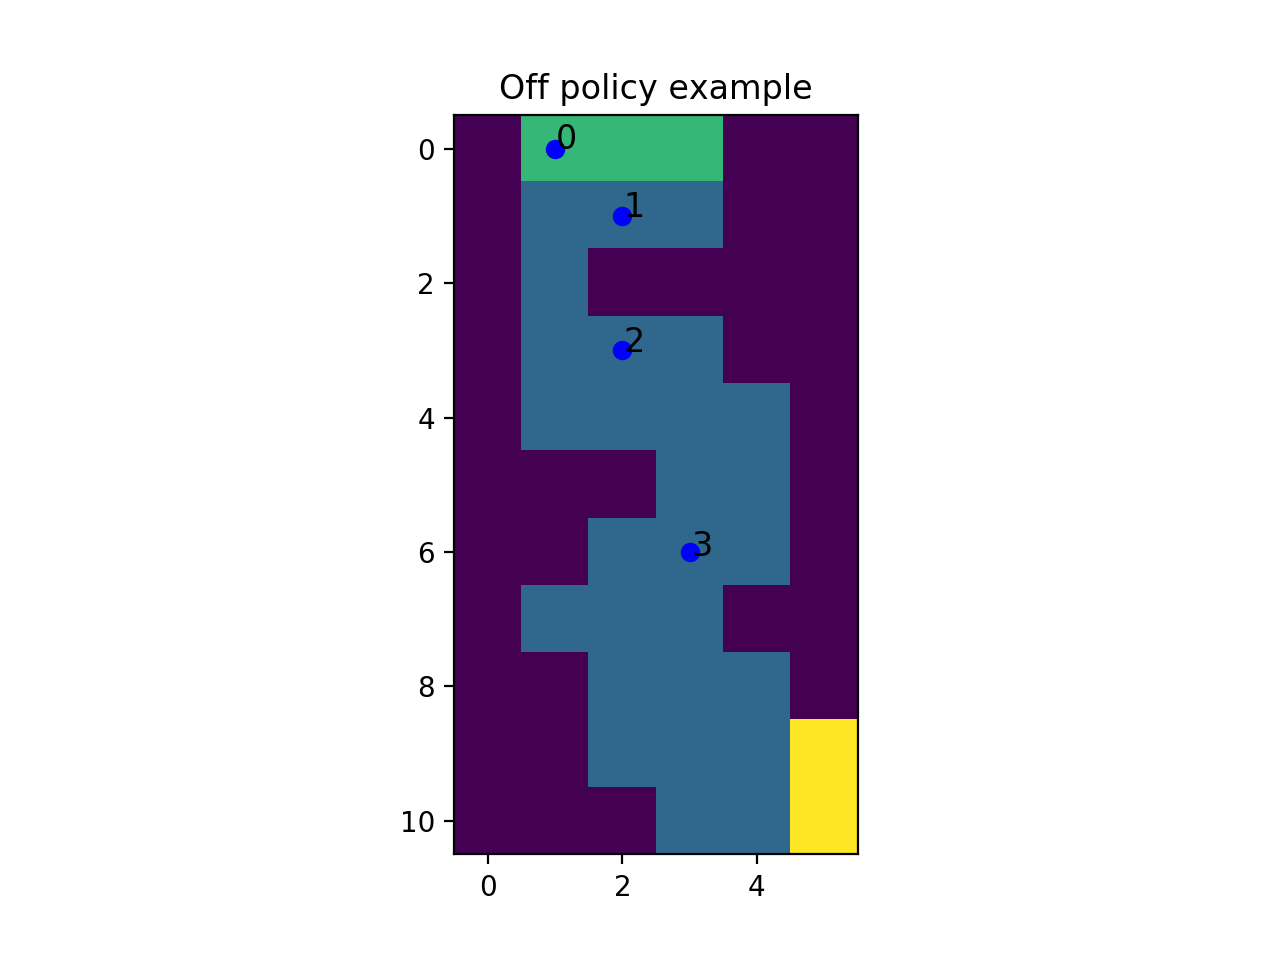

In [41]:
plt.figure()
plt.imshow(track)
plt.title("Off policy example")
for i, s in enumerate(ofs):
    x = s[1]
    y = s[0]
    plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)

In [42]:
for a in ofa:
    print(ACTIONS[a])

(1, 1)
(1, -1)
(1, 1)
(1, 1)


<IPython.core.display.Javascript object>


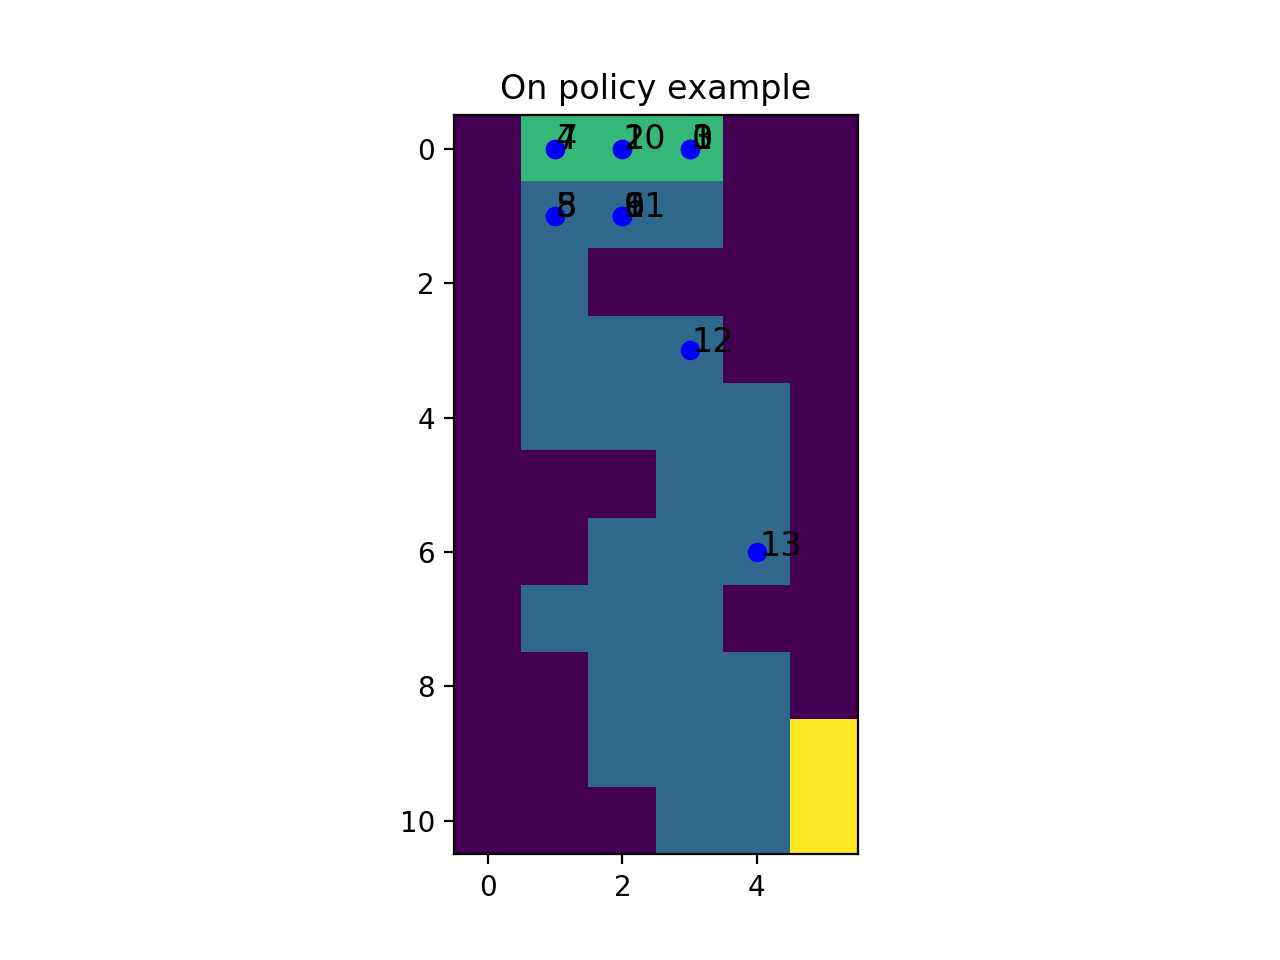

In [43]:
plt.figure()
plt.imshow(track)
plt.title("On policy example")
for i, s in enumerate(ons):
    x = s[1]
    y = s[0]
    plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)

In [44]:
for a in ona:
    print(ACTIONS[a])

(0, -1)
(0, -1)
(-1, 0)
(1, 0)
(0, 0)
(-1, -1)
(0, 1)
(0, 0)
(-1, -1)
(0, 1)
(-1, 0)
(1, 1)
(1, 0)
(1, 1)
